<span style="font-size:200%; text-align:center;"><b>Multi-mode frequency dependent squeezing:</b></span>

<span style="font-size:200%; text-align:left`;"><b>Reducing the effect of mode mismatches?</b></span>

# Table of Contents
 <p><div class="lev1"><a href="#1.-Setup-1:-Readout">1. Setup 1: Readout</a></div><div class="lev2"><a href="#1.1.-Mode-matched,-single-mode-squeezing">1.1. Mode matched, single mode squeezing</a></div><div class="lev2"><a href="#1.2.-Mode-mismatch,-single-mode-squeezing">1.2. Mode mismatch, single mode squeezing</a></div><div class="lev2"><a href="#1.3.-Multimode-squeezing">1.3. Multimode squeezing</a></div><div class="lev1"><a href="#2.-Setup-2:-Filter-cavity-and-readout">2. Setup 2: Filter cavity and readout</a></div><div class="lev2"><a href="#2.1.-Mode-matched">2.1. Mode matched</a></div><div class="lev2"><a href="#2.2.-Mode-mismatched">2.2. Mode mismatched</a></div>

The aim is to check whether it is possible to use multi-mode squeezing to reduce the sensitivity to mode mismatch for squeezing injection.

Loading packages we need.

In [80]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pykat import finesse
from pykat.commands import *
# from IPython.display import display, HTML
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

# 1. Setup 1: Readout

<img src="\files\setup1.png" width="700px" >

The left one is the case with all modes $\mathrm{LG}_{mn}$ in vacuum states and in the right the $\mathrm{LG}_{00}$ is in a squeezed state while all HOMs are in vacuum states. Instead of the homodyne detection scheme above, we make the Beam splitter highly refletive and use more laser power. This effectively removes the vacuum fluctuations coming from the laser port in the x-detector. The Finesse model:

In [81]:
basekat = finesse.kat()
basekat.verbose = True
basecode = '''
# Local oscillator in west arm
l L0 1k 0 nL0       # Laser (P = 1 kW, offset f = 0)
# Squeezer in South arm
sq SQ1 0 10 0 nS    # Squeezer (f=0, r = 10db, angle = 0 deg)

# Beam splitter (R = 0.999, T = 0.001, phi = 0 deg, AoI = 45 deg)
bs BS 0.999 0.001 0 45 nL0BS dump nXBS nSBS

# West arm, laser to beam splitter
s lBS 1 nL0 nL0BS   # Space (1 m)
# x-arm, BS to node detectors
s lX 1 nXBS nX      # Space (1 m)
# South, Squeezer to BS
s lS 1 nS nSBS      # Space (1 m)
'''
basekat.parseCommands(basecode)

## 1.1. Mode matched, single mode squeezing

Using pure fundamental modes both for laser and squeezer. Sweeping the laser phase while detecting the shot noise with and wihtout squeezing. Simulation instructions:

In [82]:
# Copying the base optical model
kat1 = basekat.deepcopy()
# Telling Finesse to be quiet. 
kat1.verbose = False
# Finesse code, adding to the model
code = '''
## Signals ## 
fsig noise 1k                 # Setting quantum noise (f = 1 kHz)

## Detectors ## 
qshot vac 1 $fs 0 nX          # Shot noise detector. Does not see squeezing.
                              # (Num. demods. = 1, demod. f = fsig freq)
qnoised sqzd 1 $fs 0 nX       # Quantum noise detector. Sees sqeezing.
                              # (Num. demods. = 1, demod. f = fsig freq)

## Simulation instructions ##
yaxis lin abs                 # Outputs (linear y-axis if plotted through Finesse/PyKat 
                              # commands, returns absolute values of detector outputs)
xaxis L0 phi lin -90 90 360   # Varying a parameter (component = L0, parameter = phi, 
                              # type = linear, min=-90, max=90, steps=360)
'''
# Parsing Finesse code and running simulation
kat1.parseCommands(code)
out1 = kat1.run()

Plotting results from our two detectors using the PyKat command `out.plot()`.

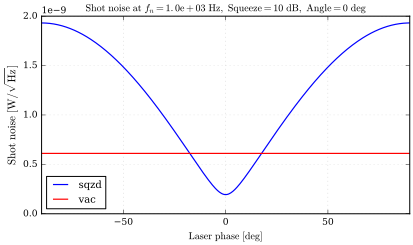

In [83]:
fig1a = out1.plot(ylabel='$\mathrm{Shot\ noise}\ [\mathrm{W}/\sqrt{\mathrm{Hz}}]$', 
                  xlabel= '$\mathrm{Laser\ phase\ [deg]}$', 
                  title = ('$\mathrm{{Shot\ noise\ at}}\ f_n = \mathrm{{ {0:.1e} }}\ '+ 
                           '\mathrm{{Hz}},\ \mathrm{{Squeeze}} = {1:.0f}\ '+
                           '\mathrm{{dB}},\ \mathrm{{Angle}}={2:.0f}\ \mathrm{{deg}}$')
                          .format(kat1.signals.f.value, kat1.SQ1.db.value,kat1.SQ1.angle.value))

The red trace is shot noise without squeezing while the blue trace is shot noise with 10 dB squeezing. To better see the squeezing level we can plot the squeezed shot noise relative to the non-squeezed shot noise.

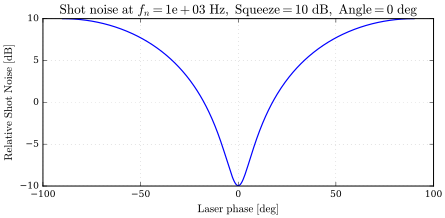

In [84]:
# Computing the ratio in dB. 
R1 = 10*np.log10( (out1['sqzd']/out1['vac'])**2)

# Plotting
fig1b = plt.figure(figsize=(7,3))
ax1 = plt.subplot(111)
ax1.plot(out1.x, R1)
ax1.set_ylabel('$\mathrm{Relative\ Shot\ Noise\ [dB]}$')
ax1.set_xlabel('$\mathrm{Laser\ phase\ [deg]}$')
ax1.set_title(('$\mathrm{{Shot\ noise\ at}}\ f_n = \mathrm{{ {0:.0e} }}\ '+
               '\mathrm{{Hz}},\ \mathrm{{Squeeze}} = {1:.0f}\ \mathrm{{dB}},\ '+
               '\mathrm{{Angle}}={2:.0f}\ \mathrm{{deg}}$'
              ).format(kat1.signals.f.value, kat1.SQ1.db.value, kat1.SQ1.angle.value))
plt.show(fig1b)

## 1.2. Mode mismatch, single mode squeezing

We set the phase of the laser and the squeezer to zero, which proved to be approximately the best phases in the figure above. Then we compute the relative shot noise for different mode compositions. As a check we use amplitude detectors (keyword `ad`) to get the amplitude of each mode. 

In [85]:
kat2 = basekat.deepcopy()
kat2.verbose= False
code = '''

## Signals ## 
fsig noise 1k                 # (Quantum noise, f = 1 kHz)

## Detectors ## 
qshot vac 1 $fs 0 nX          # Shot noise detector. Does not see squeezing.
                              # (Num. demods. = 1, demod. f = fsig freq)
qnoised sqzd 1 $fs 0 nX       # Quantum noise detector. Sees sqeezing.
                              # (Num. demods. = 1, demod. f = fsig freq)
ad a00 0 0 0 nX               # Amplitude detector (m = n = 0, offset f = 0)
ad a01 0 1 0 nX               # Amplitude detector (m = 0, n = 1, offset f = 0)

## Simulation instructions ##
yaxis lin abs                 # Outputs (linear y-axis if plotted through Finesse/PyKat 
                              # commands, returns absolute values of detector outputs)
noxaxis                       # Computing just 1 data point.

maxtem 1                      # Maximum order of TEMs considered.

'''
kat2.parseCommands(code)

# Amplitude ratio of HG_00 ( x = HG_00/(HG_00 + HG_01))
x = np.linspace(1.0e-8,1,100)
N = len(x)

# Arrays for storing results
vac = np.zeros(N)
sqzd = np.zeros(N)
A00 = np.zeros(N)
A01 = np.zeros(N)

# Setting arbitrary relative a00 content
a00 = 1
kat2.parseCommands('tem L0 0 0 {0} 0'.format(a00))

for k in range(N):
    # Looping over  ratios of a00
    
    kat_tmp = kat2.deepcopy()
    # Computing HG_01 relative "number", used in the tem command
    a01 = a00*(1-x[k])/x[k]
    # Setting HG_01 "ratio"
    kat_tmp.parseCommands('tem L0 0 1 {0} 0'.format(a01))
    # Running simulation
    out_tmp = kat_tmp.run()
    # Saving values
    vac[k] = out_tmp['vac']
    sqzd[k] = out_tmp['sqzd']
    A00[k] = out_tmp['a00']/np.sqrt(kat2.BS.T.value)
    A01[k] = out_tmp['a01']/np.sqrt(kat2.BS.T.value)
    
# Computing relative power in the fundamental mode.
X = np.abs(A00)**2/(np.abs(A00)**2 + np.abs(A01)**2)
# Ratio between squeezed and non-squeezed [dB]
R = 10*np.log10( (sqzd/vac)**2 )

Plotting results:

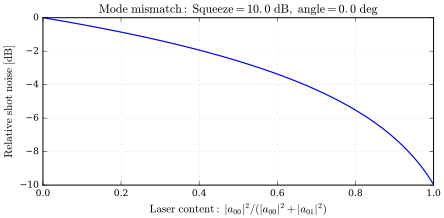

In [86]:
fig2 = plt.figure(figsize=(7,3))
ax = plt.subplot(111)
ax.plot(X,R,'b-')
# ax.plot(X,qnX,'r-', label='Squeezed $\mathrm{HG}_{00}$')
ax.set_xlabel('$\mathrm{Laser\ content:}\ |a_{00}|^2/(|a_{00}|^2+|a_{01}|^2)$')
ax.set_ylabel('$\mathrm{Relative\ shot\ noise\ [dB]}$')
ax.set_title(('$\mathrm{{Mode\ mismatch:\ Squeeze}} = {0}\ '+
              '\mathrm{{dB,\ angle }} = {1}\ \mathrm{{deg}}$'
             ).format(kat2.SQ1.db.value, kat2.SQ1.angle.value),
             fontsize=12)
ax.set_xlim(0,X.max())
plt.show(fig2)
#fig2.savefig('mode_mismatch.svg')

## 1.3. Multimode squeezing

We use the same setup as in 1.1., but now we allow the laser to have a higher order mode, and we squeeze the higher order mode.

In [87]:
kat3 = basekat.deepcopy()
kat3.verbose = False

code = '''
## Quanutm noise ##
fsig noise 1k                     # (Quantum noise, f = 1 kHz)

## Detectors ## 
qshot vac 1 $fs 0 nX              # Shot noise detector. Does not see squeezing.
                                  # (Num. demods. = 1, demod. f = fsig freq)
qnoised sqzd 1 $fs 0 nX           # Quantum noise detector. Does see sqeezing.
                                  # (Num. demods. = 1, demod. f = fsig freq)

## Instructions ##
yaxis lin abs                     # Outputs (linear y-axis, absolute values 
                                  # of detector outputs)
xaxis L0 phase lin -90 90 1440    # Varying a parameter (component = L0, parameter = phi, 
                                  # type = linear, min=-90, max=90, steps=360)
maxtem 1                          # Maximum order of TEMs considered
'''
kat3.parseCommands(code)

Considering three cases: 
* (A): Local oscillator in $\mathrm{HG}_{00}$ mode. Squeezing $\mathrm{HG}_{00}$ by 10 dB. Blue trace in figure below.
* (B): Local oscillator consists of equal parts of $\mathrm{HG}_{00}$ and $\mathrm{HG}_{01}$. Squeezing $\mathrm{HG}_{00}$ by 10 dB. Red trace in figure below.
* (C): Local oscillator consists of equal parts of $\mathrm{HG}_{00}$ and $\mathrm{HG}_{01}$. Squeezing $\mathrm{HG}_{00}$ by 10 dB and $\mathrm{HG}_{01}$ by 5 dB. Black dashed trace in figure below.

In [88]:
# A) Mode matched, squeezing HG-00
# ------------------------------
kat3a = kat3.deepcopy()
kat3a.parseCommands('''
# Mode distribution Laser (only HG-00, which is default)
tem L0 0 0 1 0              # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 0 0              # HG-01 (component=L0,m=0,n=1,factor=0,phase=0)

# Squeezing of modes (only HG-00 mode, which is default)
tem SQ1 0 0 1 0             # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 0 0             # HG-01 (component=SQ1,m=0,n=1,factor=0,phase=0)
''')
# Running simulation
out3a = kat3a.run()
# Computing relative shot noise in dB
Ra = 10*np.log10((out3a['sqzd']/out3a['vac'])**2)
# --------------------------------

# B) Mode mismatched, squeezing HG-00
# --------------------------------
kat3b = kat3.deepcopy()
kat3b.parseCommands('''
# Mode distribuion Laser (equal parts HG-00 and HG-01)
tem L0 0 0 1 0              # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 1 0              # HG-01 (component=L0,m=0,n=1,factor=1,phase=0)

# Squeezing of modes (only HG-00 mode, which is default)
tem SQ1 0 0 1 0            # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 0 0            # HG-01 (component=SQ1,m=0,n=2,factor=0,phase=0)
''')
# Running simulation
out3b = kat3b.run()
# Computing relative shot noise in dB
Rb = 10*np.log10((out3b['sqzd']/out3b['vac'])**2)
# --------------------------------

# C) Mode mismatched, squeezing HG-00 and HG-01
# --------------------------------
kat3c = kat3.deepcopy()
kat3c.parseCommands('''
# Mode distribuion Laser (equal parts HG-00 and HG-01)
tem L0 0 0 1 0             # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 1 0             # HG-01 (component=L0,m=0,n=1,factor=1,phase=0)

# Squeezing of modes (Both HG-00 and HG-01, different magnitudes)
tem SQ1 0 0 1 0            # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 0.5 0          # HG-01 (component=SQ1,m=0,n=1,factor=0.5,phase=0)
''')
# Running simulation
out3c = kat3c.run()
# Computing relative shot noise in dB
Rc = 10*np.log10((out3c['sqzd']/out3c['vac'])**2)
# --------------------------------

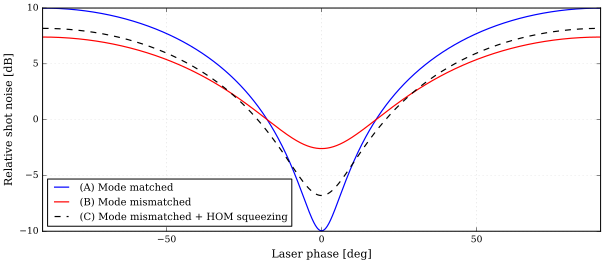

In [89]:
fig3 = plt.figure(figsize=(10,4))
ax3 = plt.subplot(111)
ax3.plot(out3a.x,Ra,'b-',label='(A) Mode matched')
ax3.plot(out3b.x,Rb,'r-',label='(B) Mode mismatched')
ax3.plot(out3c.x,Rc,'k--',label='(C) Mode mismatched + HOM squeezing')
ax3.set_xlabel('Laser phase [deg]')
ax3.set_ylabel('Relative shot noise [dB]')
ax3.set_xlim(out3a.x.min(),out3a.x.max())
ax3.legend(loc = 3,fontsize=10)
plt.show(fig3)

# 2. Setup 2: Filter cavity and readout

<img src="\files\setup2.png" width="700px" >

In [90]:
basekat2 = finesse.kat()
basekat2.verbose = False
basecode = '''
# Local oscillator in west arm
l L0 1k 0 nL0       # Laser (P = 1 kW, offset f = 0)

# Beam splitter (R = 0.999, T = 0.001, phi = 0 deg, AoI = 45 deg)
bs BS 0.999 0.001 0 45 nL0BS dump nXBS nSBS

# West arm, laser to beam splitter
s lBS 1n nL0 nL0BS   # Space (1 nm)
# x-arm, BS to node detectors
s lX 1n nXBS nX      # Space (1 nm)

# Squeezer
sq SQ1 0 10 0 nS     # Squeezer (f=0, r = 10db, angle = 0 deg)
# Squeezer to FC
s lS 1n nS nIMFC1    # Space (1 nm)

## Filter cavity ##
# -------------------
# Using beamsplitters for FC so no need for an isolator

# Beam splitter (T = 61e-6, loss=0, phi = 0 deg, AoI = 0 deg)
bs1 IMFC 61u 0 0 0 nIMFC1 nIMFC2 nIMFC3 nIMFC4
s lFC1 16 nIMFC3 nEMFC1      # Space (16 m)
s lFC2 16 nEMFC2 nIMFC4      # Space (16 m)
# Beam splitter (T=0 , loss=0, phi=8.82e-4 deg, AoI = 0 deg)
bs1 EMFC 0 0 -0.000882 0 nEMFC1 nEMFC2 dump dump

# Setting RoC of FC-mirrors, Confocal cavity
attr IMFC Rc -15.999     # RoC = -15.999 m
attr EMFC Rc  15.999     # RoC = 15.999 m

# Space from Filter cavity to beam splitter
s lFC2BS 1n nIMFC2 nSBS     # Space (1 nm)

# Defining cavity, using eigenmode of cavity as beam parameter ##
cav cavFC IMFC nIMFC3 IMFC nIMFC4
# -------------------


'''
basekat2.parseCommands(basecode)

## 2.1. Mode matched

Laser beam in the fundamental mode, and we squeeze the very same mode while sweeping the frequency of the quantum noise.

In [91]:
kat4 = basekat2.deepcopy()
kat4.verbose = False

code = '''
## Quanutm noise ##
fsig noise 1k                     # (Quantum noise, f = 1 kHz)

## Detectors ## 
qshot vac 1 $fs 0 nX              # Shot noise detector. Does not see squeezing.
                                  # (Num. demods. = 1, demod. f = fsig freq)
qnoised sqzd 1 $fs 0 nX           # Quantum noise detector. Does see sqeezing.
                                  # (Num. demods. = 1, demod. f = fsig freq)

## Instructions ##
yaxis lin abs                     # Outputs (linear y-axis, absolute values 
                                  # of detector outputs)
xaxis noise f lin 1 1k 200        # Varying a parameter (component = L0, parameter = phi, 
                                  # type = linear, min=-90, max=90, steps=360)
maxtem 2                          # Maximum order of TEMs considered
'''
kat4.parseCommands(code)
out4 = kat4.run()

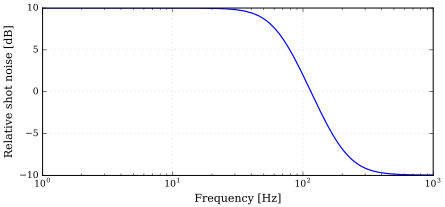

In [92]:
R4 = 10*np.log10((out4['sqzd']/out4['vac'])**2)
fig4 = plt.figure(figsize=(7,3))
ax4 = plt.subplot(111)
ax4.plot(out4.x,R4,'b-')
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('Relative shot noise [dB]')
ax4.set_xlim(out4.x.min(),out4.x.max())
ax4.set_xscale('log')
plt.show(fig4)

## 2.2. Mode mismatched

We do the same as above, but now with three different mode compositions as descibred further below. First we add the simulation instructions.

In [248]:
kat5 = basekat2.deepcopy()
kat5.verbose = False

code = '''
## Quanutm noise ##
fsig noise 1k                     # (Quantum noise, f = 1 kHz)

## Detectors ## 
qshot vac 1 $fs 0 nX              # Shot noise detector. Does not see squeezing.
                                  # (Num. demods. = 1, demod. f = fsig freq)
qnoised sqzd 1 $fs 0 nX           # Quantum noise detector. Does see sqeezing.
                                  # (Num. demods. = 1, demod. f = fsig freq)

## Instructions ##
yaxis lin abs                     # Outputs (linear y-axis, absolute values 
                                  # of detector outputs)
xaxis noise f lin 1 1k 200        # Varying a parameter (component = L0, parameter = phi, 
                                  # type = linear, min=-90, max=90, steps=360)
maxtem 2                          # Maximum order of TEMs considered
'''
kat5.parseCommands(code)

Considering three cases: 
* (A): Local oscillator in $\mathrm{HG}_{00}$ mode. Squeezing $\mathrm{HG}_{00}$ by 10 dB. Blue trace in figure below.
* (B): Local oscillator consists of equal parts of $\mathrm{HG}_{00}$ and $\mathrm{HG}_{01}$. Squeezing $\mathrm{HG}_{00}$ by 10 dB. Red trace in figure below.
* (C): Local oscillator consists of equal parts of $\mathrm{HG}_{00}$ and $\mathrm{HG}_{01}$. Squeezing $\mathrm{HG}_{00}$ by 10 dB and $\mathrm{HG}_{01}$ by 5 dB. Black dashed trace in figure below.

In [268]:
# A) Mode matched, squeezing HG-00
# ------------------------------
kat5a = kat5.deepcopy()
kat5a.parseCommands('''
# Mode distribution Laser (only HG-00, which is default)
tem L0 0 0 1 0              # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 0 0              # HG-01 (component=L0,m=0,n=1,factor=0,phase=0)

# Squeezing of modes (only HG-00 mode, which is default)
tem SQ1 0 0 1 0             # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 0 0             # HG-01 (component=SQ1,m=0,n=1,factor=0,phase=0)
''')
# Running simulation
out5a = kat5a.run()
# Computing relative shot noise in dB
R5a = 10*np.log10((out5a['sqzd']/out5a['vac'])**2)
# --------------------------------

# B) Mode mismatched, squeezing HG-00
# --------------------------------
kat5b = kat5.deepcopy()
kat5b.parseCommands('''
# Mode distribuion Laser (equal parts HG-00 and HG-01)
tem L0 0 0 1 0              # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 1 0              # HG-01 (component=L0,m=0,n=1,factor=1,phase=0)

# Squeezing of modes (only HG-00 mode, which is default)
tem SQ1 0 0 1 0            # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 0 0            # HG-01 (component=SQ1,m=0,n=2,factor=0,phase=0)
''')
# Running simulation
out5b = kat5b.run()
# Computing relative shot noise in dB
R5b = 10*np.log10((out5b['sqzd']/out5b['vac'])**2)
# --------------------------------

# C) Mode mismatched, squeezing HG-00 and HG-01 (not frequency depedent HG-01 squeezing)
# --------------------------------
kat5c = kat5.deepcopy()
kat5c.parseCommands('''
# Mode distribuion Laser (equal parts HG-00 and HG-01)
tem L0 0 0 1 0             # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 1 0             # HG-01 (component=L0,m=0,n=1,factor=1,phase=0)

# Squeezing of modes (Both HG-00 and HG-01, different magnitudes)
tem SQ1 0 0 1 0            # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 1 0            # HG-01 (component=SQ1,m=0,n=1,factor=0.5,phase=0)
''')
# Running simulation
out5c = kat5c.run()
# Computing relative shot noise in dB
R5c = 10*np.log10((out5c['sqzd']/out5c['vac'])**2)
# --------------------------------

# D) Mode mismatched, squeezing HG-00 and HG-01 with optimised phase of HG-01
# (not frequency depedent HG-01 squeezing)
# --------------------------------
kat5d = kat5.deepcopy()
kat5d.parseCommands('''
# Mode distribuion Laser (equal parts HG-00 and HG-01)
tem L0 0 0 1 0             # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 1 0             # HG-01 (component=L0,m=0,n=1,factor=1,phase=0)

# Squeezing of modes (Both HG-00 and HG-01, different magnitudes)
tem SQ1 0 0 1 0            # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 1 -90       # HG-01 (component=SQ1,m=0,n=1,factor=0.5,phase=0)
''')
# Running simulation
out5d = kat5d.run()
# Computing relative shot noise in dB
R5d = 10*np.log10((out5d['sqzd']/out5d['vac'])**2)
# --------------------------------


# E) Mode mismatched, squeezing HG-00 and HG-01, both frequency depedent
# --------------------------------
kat5e = kat5.deepcopy()
kat5e.parseCommands('''
# Mode distribuion Laser (equal parts HG-00 and HG-01)
tem L0 0 0 1 0             # HG-00 (component=L0,m=0,n=0,factor=1,phase=0)
tem L0 0 1 1 0             # HG-01 (component=L0,m=0,n=1,factor=1,phase=0)

# Squeezing of modes (Both HG-00 and HG-01, different magnitudes)
tem SQ1 0 0 1 0            # HG-00 (component=SQ1,m=0,n=0,factor=1,phase=0)
tem SQ1 0 1 1 90           # HG-01 (component=SQ1,m=0,n=1,factor=0.5,phase=0)

attr lFC1 g 180
attr lFC2 g 180
''')
# Running simulation
out5e = kat5e.run()
# Computing relative shot noise in dB
R5e = 10*np.log10((out5e['sqzd']/out5e['vac'])**2)
# --------------------------------

Plotting:

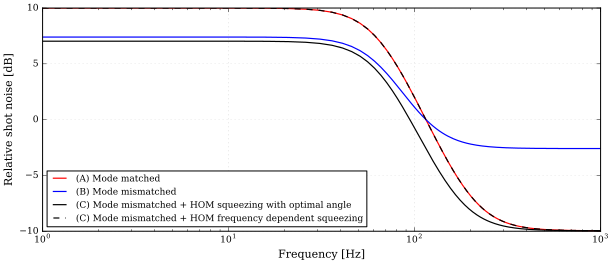

In [266]:
fig5 = plt.figure(figsize=(10,4))
ax5 = plt.subplot(111)
ax5.plot(out5a.x,R5a,'r-',label='(A) Mode matched')
ax5.plot(out5b.x,R5b,'b-',label='(B) Mode mismatched')
# ax5.plot(out5c.x,R5c,'k-',label='(C) Mode mismatched + HOM squeezing')
ax5.plot(out5d.x,R5d,'k-',label='(C) Mode mismatched + HOM squeezing with optimal angle')
ax5.plot(out5e.x,R5e,'k--',label='(C) Mode mismatched + HOM frequency dependent squeezing')


ax5.set_xlabel('Frequency [Hz]')
ax5.set_ylabel('Relative shot noise [dB]')
ax5.set_xlim(out5a.x.min(),out5a.x.max())
ax5.legend(loc = 3,fontsize=9)
ax5.set_xscale('log')
plt.show(fig5)